In [125]:
#Important packages to install uncomment if you dont have it
#!pip install kneed
#!pip install yellowbrick
#!pip install threadpoolctl==3.1.0

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from  sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

In [127]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
random_seed= 42

In [128]:
edges = './dataset/UofT_edges.csv'
nodes = './dataset/UofT_nodes.csv'
occ_risk = './dataset/UofT_occupation_risk.csv'



In [ ]:
#Config parameters 
nK = 20  # to check silhouette score upto nk=20
latent_dim =10 # Change to latent dimension required.
version = 5 # specify a version to save results of models

In [129]:
edge_df = pd.read_csv(edges)
nodes_df = pd.read_csv(nodes)
occrisk_df = pd.read_csv(occ_risk)

In [130]:
ed_nodes_df = pd.merge(nodes_df,edge_df, left_on= 'CUSTOMER_ID',right_on = 'source')

In [131]:
#ed_nodes_occrisk_df.columns

In [132]:
ed_nodes_occrisk_df = pd.merge(ed_nodes_df,occrisk_df, left_on= 'OCPTN_NM',right_on = 'code')

In [133]:
ed_combined_dataset= ed_nodes_occrisk_df.groupby(by=['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID', 'source', 'target', 'code', 'occupation_risk']).sum()

In [134]:
df_train = ed_combined_dataset.reset_index()
#df_test = pd.read_csv(ds_test)

In [135]:
df_train.columns

Index(['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
       'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN',
       'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID',
       'source', 'target', 'code', 'occupation_risk', 'emt'],
      dtype='object')

In [136]:
# So only difference in median household income which is the response
# Let us separate response from training
df_train['RISK'].replace(['low','medium','high'],[0,1,2],inplace=True)
y = df_train['RISK']
df_train=df_train.drop(['RISK'],axis= 1)

# Feature Engineering

### 1. Feature Engineering - Creation of ratios

In [137]:
# Any feature engineering we wish to do will go here
'''
# avg_tenure=df_train['Total Households for Tenure']/df_train['Total Households']
#avg_owner= df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']
df_train['avg_tenure'] = None
df_train['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']

df_train['avg_owner'] = None
df_train['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']

#df_train['Total_hs_pdc_b1961'] = None
#df_train['Total_hs_pdc_b1961'] = df_train['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']

#df_train['Total_hs_pdc_1961_1980'] = None
#df_train['Total_hs_pdc_1961_1980'] = df_train['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_1981_1900'] = None
df_train['Total_hs_pdc_1981_1900'] = df_train['Total Households For Period Of Construction Built Between 1981 And 190']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_1991_2000'] = None
df_train['Total_hs_pdc_1991_2000'] = df_train['Total Households For Period Of Construction Built Between 1991 And 2000']/df_train['Total Households for Tenure']

df_train['Total_hs_pdc_2001_2005'] = None
df_train['Total_hs_pdc_2001_2005'] = df_train['Total Households For Period Of Construction Built Between 2001 And 2005']/df_train['Total Households for Tenure']

df_test['avg_tenure'] = None
df_test['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']

df_test['avg_owner'] = None
df_test['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']

#df_test['Total_hs_pdc_b1961'] = None
#df_test['Total_hs_pdc_b1961'] = df_test['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']

#df_test['Total_hs_pdc_1961_1980'] = None
#df_test['Total_hs_pdc_1961_1980'] = df_test['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_1981_1900'] = None
df_test['Total_hs_pdc_1981_1900'] = df_test['Total Households For Period Of Construction Built Between 1981 And 190']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_1991_2000'] = None
df_test['Total_hs_pdc_1991_2000'] = df_test['Total Households For Period Of Construction Built Between 1991 And 2000']/df_train['Total Households for Tenure']

df_test['Total_hs_pdc_2001_2005'] = None
df_test['Total_hs_pdc_2001_2005'] = df_test['Total Households For Period Of Construction Built Between 2001 And 2005']/df_train['Total Households for Tenure']
'''

"\n# avg_tenure=df_train['Total Households for Tenure']/df_train['Total Households']\n#avg_owner= df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']\ndf_train['avg_tenure'] = None\ndf_train['avg_tenure'] = df_train['Total Households for Tenure']/df_train['Total Households']\n\ndf_train['avg_owner'] = None\ndf_train['avg_owner'] = df_train['Dwellings by Tenure Owner']/df_train['Total Households for Tenure']\n\n#df_train['Total_hs_pdc_b1961'] = None\n#df_train['Total_hs_pdc_b1961'] = df_train['Total Households For Period Of Construction Built Before 1961']/df_train['Total Households for Tenure']\n\n#df_train['Total_hs_pdc_1961_1980'] = None\n#df_train['Total_hs_pdc_1961_1980'] = df_train['Total Households For Period Of Construction Built Between 1961 And 1980']/df_train['Total Households for Tenure']\n\ndf_train['Total_hs_pdc_1981_1900'] = None\ndf_train['Total_hs_pdc_1981_1900'] = df_train['Total Households For Period Of Construction Built Between 1981 And 190

****Start with data visualization and cleaning**** 

In [138]:
# Starting with checking for type of variables in data
[col+" "+ str(type(df_train[col][0])) for col in df_train.columns]

["BIRTH_DT <class 'str'>",
 "CUST_ADD_DT <class 'str'>",
 "OCPTN_NM <class 'numpy.float64'>",
 "RES_CNTRY_CA <class 'numpy.int64'>",
 "CNTRY_OF_INCOME_CA <class 'numpy.int64'>",
 "PEP_FL <class 'numpy.float64'>",
 "CASH_SUM_IN <class 'numpy.float64'>",
 "CASH_CNT_IN <class 'numpy.float64'>",
 "CASH_SUM_OUT <class 'numpy.float64'>",
 "CASH_CNT_OUT <class 'numpy.float64'>",
 "WIRES_SUM_IN <class 'numpy.float64'>",
 "WIRES_CNT_IN <class 'numpy.float64'>",
 "WIRES_SUM_OUT <class 'numpy.float64'>",
 "WIRES_CNT_OUT <class 'numpy.float64'>",
 "COUNTRY_RISK_INCOME <class 'str'>",
 "COUNTRY_RISK_RESIDENCY <class 'str'>",
 "NAME <class 'str'>",
 "GENDER <class 'str'>",
 "CUSTOMER_ID <class 'numpy.float64'>",
 "source <class 'numpy.float64'>",
 "target <class 'numpy.float64'>",
 "code <class 'numpy.int64'>",
 "occupation_risk <class 'str'>",
 "emt <class 'numpy.float64'>"]

In [139]:
df_train.columns

Index(['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
       'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN',
       'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'NAME', 'GENDER', 'CUSTOMER_ID', 'source',
       'target', 'code', 'occupation_risk', 'emt'],
      dtype='object')

In [140]:
# Defining possible categoricals
#'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL'
df_train['RES_CNTRY_CA'] = df_train['RES_CNTRY_CA'].astype("string")
df_train['CNTRY_OF_INCOME_CA'] = df_train['CNTRY_OF_INCOME_CA'].astype("string")
df_train['PEP_FL']= df_train['PEP_FL'].astype("string")

#Removing id we store it in a variable just in case we need it
customer_ids= df_train.CUSTOMER_ID
df_train= df_train.drop(['CUSTOMER_ID'],axis=  1)
source = df_train.source
df_train= df_train.drop(['source'],axis=  1)
target = df_train.target
df_train= df_train.drop(['target'],axis=  1)

In [141]:
birth_dates =  df_train.BIRTH_DT
df_train= df_train.drop(['BIRTH_DT'],axis=  1)
customer_add_date =  df_train.CUST_ADD_DT
df_train= df_train.drop(['CUST_ADD_DT'],axis=  1)
customer_names =  df_train.NAME
df_train= df_train.drop(['NAME'],axis=  1)





In [142]:
df_train.GENDER.replace(['Female','Male'],[0,1],inplace=True)
df_train['GENDER']= df_train['GENDER'].astype("string")
#customer_genders = df_train.GENDER 
#df_train= df_train.drop(['GENDER'],axis=  1)

In [143]:
df_train.occupation_risk.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train['occupation_risk']= df_train['GENDER'].astype("string")

In [144]:
df_train.head(5)

OCPTN_NM RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  CASH_SUM_IN  CASH_CNT_IN  \
0     724.0            1                  1    0.0     1380.630          2.0   
1      89.0            1                  1    0.0     1769.803          4.0   
2     817.0            1                  1    0.0     2832.955          4.0   
3     513.0            1                  1    0.0     3272.787          4.0   
4      92.0            1                  1    0.0     1635.385          3.0   

   CASH_SUM_OUT  CASH_CNT_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_SUM_OUT  \
0      3416.367           8.0      151868.0           5.0       153283.0   
1      7949.068          19.0      291919.0          33.0        95374.0   
2     29734.878          86.0      542327.0         195.0       415222.0   
3      6913.618          14.0      166453.0          45.0       260733.0   
4      7253.431          14.0       59870.0          22.0       187544.0   

   WIRES_CNT_OUT COUNTRY_RISK_INCOME COUNTRY_RISK_RESIDENCY GENDER  code  \
0           45.0                 Low                    Low      0   724   
1           17.0                 Low                    Low      1    89   
2          261.0                 Low                    Low      0   817   
3          126.0                 Low                    Low      0   513   
4          106.0                 Low                    Low      0    92   

  occupation_risk          emt  
0               0  2956.598517  
1               1   307.773324  
2               0   106.606069  
3               0  1047.324853  
4               0   153.411922

In [145]:
#Segregating numericals from categoricals
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train_numeric = df_train.select_dtypes(include=numerics)
numeric_cols= df_train_numeric.columns
categorical_cols= [col for col in df_train.columns if col not in df_train_numeric.columns]
df_train_categorical= df_train[categorical_cols]

### 2. Feature Engineering- Null Values Removal

In [146]:
# Thus we see all are numerical
#Let us check for null values
print(f"Null values in Training = {df_train.isnull().sum().sum()} " )

Null values in Training = 0 


In [147]:
# in case feature engineer open this code to backfill missing values right now no null values
'''
df_train= df_train.fillna(method= 'backfill')
df_test= df_test.fillna(method= 'backfill')


df_train= df_train.replace(np.inf, 0) 
df_test= df_test.replace(np.inf, 0) 
'''

"\ndf_train= df_train.fillna(method= 'backfill')\ndf_test= df_test.fillna(method= 'backfill')\n\n\ndf_train= df_train.replace(np.inf, 0) \ndf_test= df_test.replace(np.inf, 0) \n"

### 3. Feature Engineering - Outlier Detection and removal 

***Start with checking value counts across each feature to analyse if any abnormally high frequencies are present for data points***

In [148]:
for col in df_train_numeric.columns:
    print(col)
    print(df_train[col].value_counts())

OCPTN_NM
25.0     85974
89.0     70927
513.0    61574
724.0    51890
817.0    44291
         ...  
663.0        1
684.0        1
666.0        1
459.0        1
86.0         1
Name: OCPTN_NM, Length: 548, dtype: int64
CASH_SUM_IN
7009.000     28
41639.000    27
3862.000     27
3906.000     25
1750.000     25
             ..
17132.701     1
55075.000     1
4935.567      1
3319.985      1
68417.000     1
Name: CASH_SUM_IN, Length: 193298, dtype: int64
CASH_CNT_IN
1.0     34502
2.0     34462
3.0     33132
4.0     30669
5.0     28972
        ...  
75.0        2
68.0        2
79.0        2
76.0        1
71.0        1
Name: CASH_CNT_IN, Length: 76, dtype: int64
CASH_SUM_OUT
4155.000     30
23159.000    28
24923.000    27
9361.000     27
11165.000    27
             ..
6559.700      1
1715.080      1
225.433       1
2229.000      1
0.000         1
Name: CASH_SUM_OUT, Length: 185167, dtype: int64
CASH_CNT_OUT
2.0      13062
1.0      12971
5.0      12874
3.0      12802
6.0      12518
         ...

***Visualizing data spread and distribution along features***

In [149]:
#Code uncomment to get visualization of scatter plot for identifying outliers 
'''# No null values so we check for outliers
#Let us check what is the unique value distribution of the variables.
for col in df_train_numeric.columns:
    sns.scatterplot([x for x in range(len(df_train_numeric))],df_train_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]
    sns.lineplot([x for x in range(len(df_train_numeric))],df_train_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)
    plt.legend()

    plt.show()''' 

"# No null values so we check for outliers\n#Let us check what is the unique value distribution of the variables.\nfor col in df_train_numeric.columns:\n    sns.scatterplot([x for x in range(len(df_train_numeric))],df_train_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]\n    sns.lineplot([x for x in range(len(df_train_numeric))],df_train_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)\n    plt.legend()\n\n    plt.show()"

In [150]:
df_train_2_numeric= df_train_numeric.copy()
df_train_2_categorical = df_train_categorical.copy()
y_2= y.copy()

In [151]:
df_train_2_numeric.isnull().sum().sum()

0

***We opted for isolation tree based outlier removal, -1 signifies value to be removed*** 

In [152]:
# Box cox is not able to remove outliers we use Isolation Forest to remove outliers

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(df_train_2_numeric)

D:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [153]:
#So number of rows to remove =500
pd.DataFrame(yhat).value_counts()

 1    415078
-1     46120
dtype: int64

In [154]:
#almost 46120 ouliers
y_2

0         0
1         0
2         0
3         0
4         0
         ..
461193    0
461194    0
461195    0
461196    0
461197    0
Name: RISK, Length: 461198, dtype: int64

In [155]:
df_train_2_numeric= df_train_2_numeric[yhat!=-1]
y_2= y_2[yhat!=-1]

In [156]:
df_train_2_categorical = df_train_2_categorical[yhat!=-1]

In [157]:
df_train_2_numeric.describe()

OCPTN_NM    CASH_SUM_IN    CASH_CNT_IN   CASH_SUM_OUT  \
count  415078.000000  415078.000000  415078.000000  415078.000000   
mean      360.565470   17370.770635       9.033543   23995.641598   
std       296.698752   19144.504459       7.825886   27509.181079   
min         0.000000       0.000000       0.000000       0.000000   
25%        89.000000    3310.006000       3.000000    4311.222000   
50%       334.000000    8538.000000       7.000000   11165.487000   
75%       724.000000   27036.000000      13.000000   36621.000000   
max       840.000000  133489.784000      50.000000  177883.000000   

        CASH_CNT_OUT  WIRES_SUM_IN   WIRES_CNT_IN  WIRES_SUM_OUT  \
count  415078.000000  4.150780e+05  415078.000000   4.150780e+05   
mean       22.257877  3.499286e+06      80.449173   1.430555e+06   
std        17.778505  4.793726e+06      60.494944   1.799851e+06   
min         0.000000  0.000000e+00       0.000000   1.000000e+00   
25%         8.000000  1.672300e+05      32.000000   1.412265e+05   
50%        18.000000  9.262235e+05      68.000000   4.697140e+05   
75%        32.000000  5.389303e+06     116.000000   2.258622e+06   
max       123.000000  3.289073e+07     522.000000   1.443571e+07   

       WIRES_CNT_OUT           code            emt  
count  415078.000000  415078.000000  415078.000000  
mean      145.214261     360.565470    1018.771883  
std       109.335442     296.698752    1245.953374  
min         0.000000       0.000000      56.912763  
25%        58.000000      89.000000     154.098318  
50%       123.000000     334.000000     388.981079  
75%       210.000000     724.000000    1476.053092  
max       834.000000     840.000000    5394.814418

In [158]:
df_train_numeric.describe()

OCPTN_NM    CASH_SUM_IN    CASH_CNT_IN   CASH_SUM_OUT  \
count  461198.000000  461198.000000  461198.000000  461198.000000   
mean      364.543649   20854.509396      10.447838   30396.139210   
std       297.615786   23151.687301       9.569255   35691.101621   
min         0.000000       0.000000       0.000000       0.000000   
25%        89.000000    3664.793000       3.000000    4831.655000   
50%       334.000000   10325.656500       7.000000   13918.000000   
75%       724.000000   32512.750000      15.000000   46018.750000   
max       840.000000  171717.689000      79.000000  279972.000000   

        CASH_CNT_OUT  WIRES_SUM_IN   WIRES_CNT_IN  WIRES_SUM_OUT  \
count  461198.000000  4.611980e+05  461198.000000   4.611980e+05   
mean       26.095133  4.523367e+06      90.112858   1.826825e+06   
std        22.600547  6.096265e+06      70.315016   2.290822e+06   
min         0.000000  0.000000e+00       0.000000   1.000000e+00   
25%         9.000000  1.899140e+05      35.000000   1.599130e+05   
50%        20.000000  1.671322e+06      75.000000   7.516030e+05   
75%        37.000000  6.876954e+06     129.000000   2.832130e+06   
max       198.000000  4.659830e+07     585.000000   1.893074e+07   

       WIRES_CNT_OUT           code            emt  
count  461198.000000  461198.000000  461198.000000  
mean      164.344056     364.543649    1080.295040  
std       129.228159     297.615786    1305.246089  
min         0.000000       0.000000      56.912763  
25%        63.000000      89.000000     155.806445  
50%       135.000000     334.000000     393.797725  
75%       235.000000     724.000000    1516.374130  
max      1083.000000     840.000000    5394.814418

In [159]:
#Checking out outliers

In [160]:
'''for col in df_train_2_numeric.columns:
    sns.scatterplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]
    sns.lineplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)
    plt.legend()

    plt.show()'''

"for col in df_train_2_numeric.columns:\n    sns.scatterplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col]).set(title=f'Outlier Detection in {col}')#df_train[col]\n    sns.lineplot([x for x in range(len(df_train_2_numeric))],df_train_2_numeric[col].mean() , color='g',legend='full', linewidth=1.2, markersize=13)\n    plt.legend()\n\n    plt.show()"

***We were able to remove a lot of outliers almost 500***


### Feature Engineering 4.1 -  Fixing skewness (Using Box-cox)

In [161]:
df_train_3_numeric = df_train_2_numeric.copy()
df_train_3_categorical = df_train_2_categorical.copy()

y_3 = y_2.copy()
#df_test_3= df_test_2.copy()

***Using Box Cox transformation to remove skewness***

In [162]:
# Let us remove skewness 
lambda_dict = {}
def remove_skewness(df,colname):
    '''
    Function takes in a dataframe and column name and return 
    dataframe with skewness removed in the input column.
    
    Args:
    df: Dataframe to remove skewness from.
    colname: Name of the column to remove skewness from.
    
    Returns:
    df: dataframe with <colname> column's skewness removed.
    
    '''
    print('******************************')
    print("Before Removing Skewness")
    print(colname)
    print("Skewness: %f" % df[colname].skew())
    print("Kurtosis: %f" % df[colname].kurt())
    fitted_lambda=0
    try:
        _,fitted_lambda = stats.boxcox(df[colname])
        df[colname] = _
        #df[colname], fitted_lambda = stats.boxcox(df[colname])
    except:
        print('Cannot scale')
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    print("After Removing Skewness")
    # print(colname)
    print("Skewness: %f" % df[colname].skew())
    print("Kurtosis: %f" % df[colname].kurt())
    lambda_dict[colname]=fitted_lambda
    return df

In [163]:
df_train_3_numeric.isnull().sum().sum()

0

In [164]:
#for  col in df_train_3_numeric.columns:
#    df_train_3_numeric = remove_skewness(df_train_3_numeric,col)
    

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>,
        <AxesSubplot: title={'center': 'CASH_CNT_IN'}>],
       [<AxesSubplot: title={'center': 'CASH_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'CASH_CNT_OUT'}>,
        <AxesSubplot: title={'center': 'WIRES_SUM_IN'}>],
       [<AxesSubplot: title={'center': 'WIRES_CNT_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'code'}>,
        <AxesSubplot: title={'center': 'emt'}>, <AxesSubplot: >]],
      dtype=object)

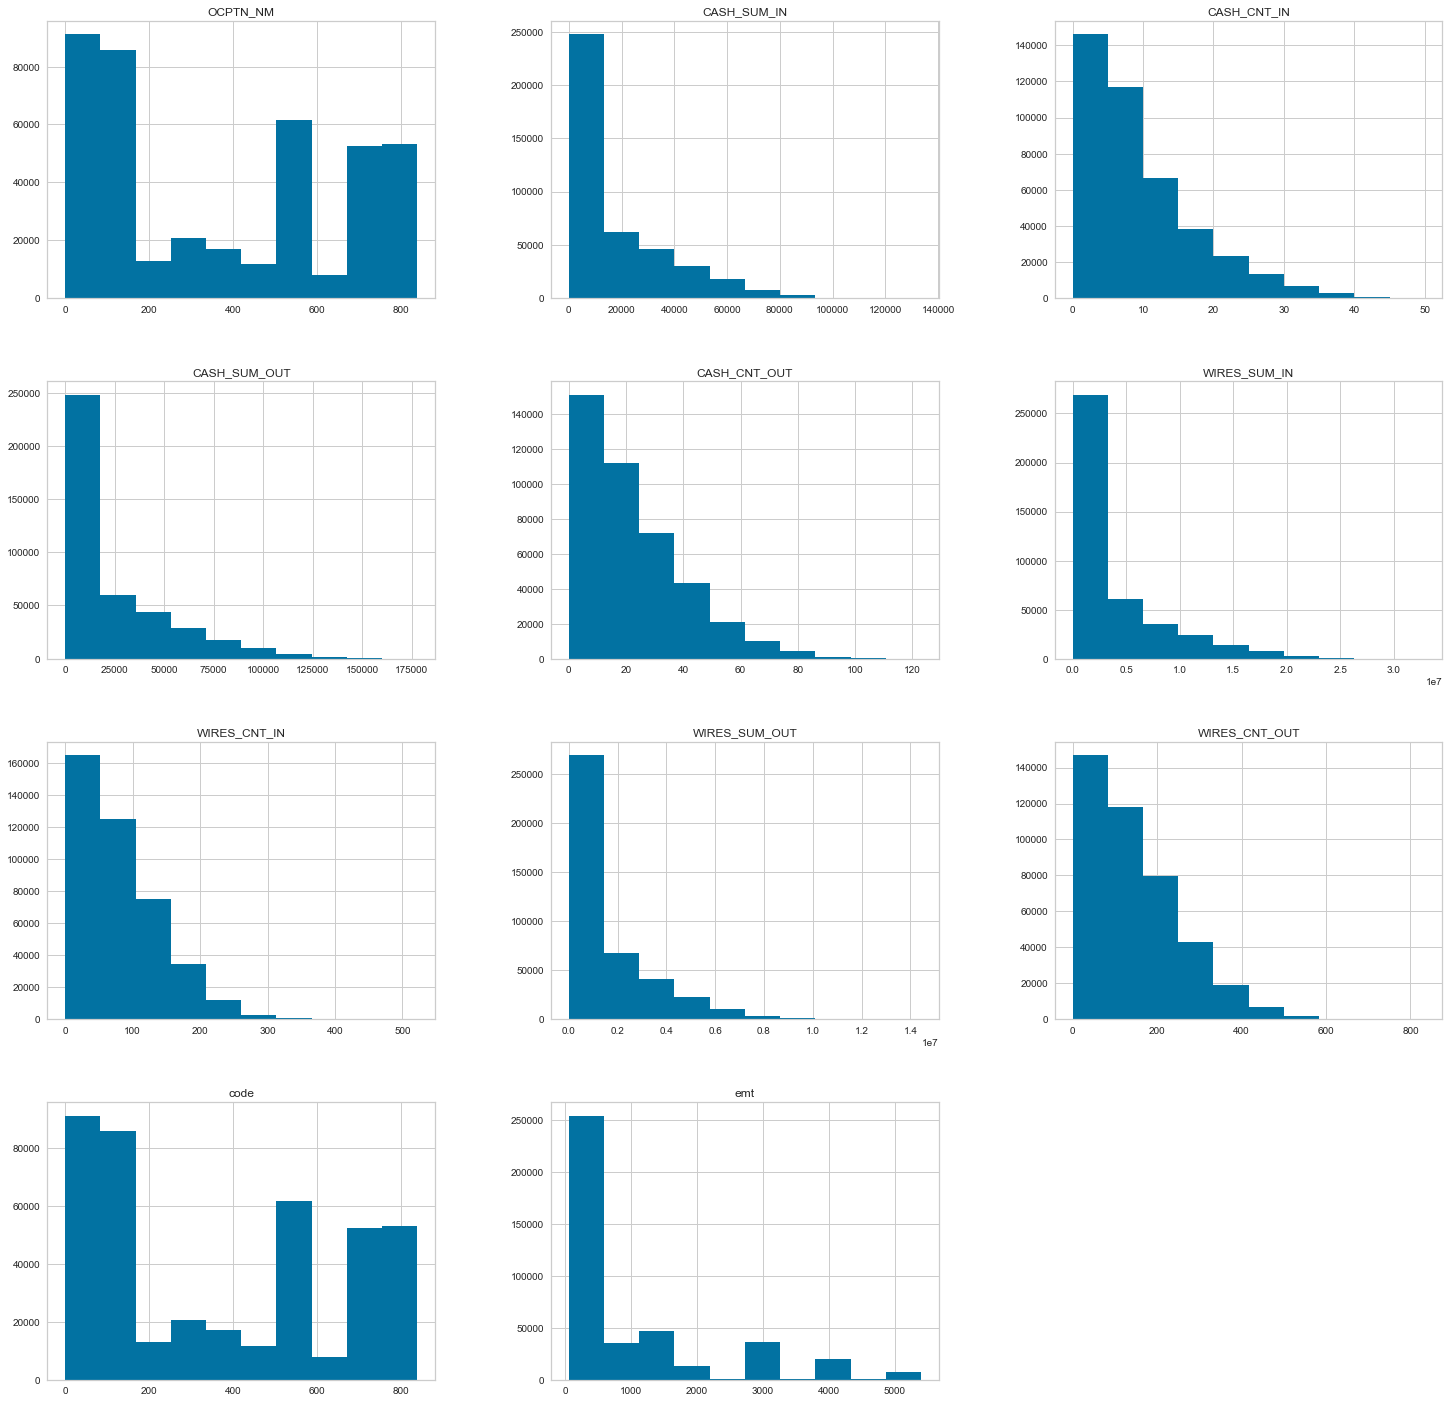

In [165]:
df_train_3_numeric.hist(figsize=(25,25))

***Using log transform to remove skewness and Kurtosis***

In [166]:
# Added utility list of categorical for scalability.
numericals = df_train_3_numeric.columns #"Total Households For Period Of Construction Built Between 1981 And 190"
categoricals = df_train_categorical.columns #[col for col in df_train.columns if col not in categoricals]

In [167]:
df_train_4_numerical = df_train_3_numeric
df_train_4_categorical = df_train_3_categorical


In [168]:
y_3.shape

(415078,)

In [169]:
df_train_4_numerical.isnull().sum()

OCPTN_NM         0
CASH_SUM_IN      0
CASH_CNT_IN      0
CASH_SUM_OUT     0
CASH_CNT_OUT     0
WIRES_SUM_IN     0
WIRES_CNT_IN     0
WIRES_SUM_OUT    0
WIRES_CNT_OUT    0
code             0
emt              0
dtype: int64

### Feature Engineering 5-  Checking correlation between numerical variables

In [170]:

corr_matrix=df_train_4_numerical.corr()

upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.70)]

<ipython-input-170-e723ac971bc0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


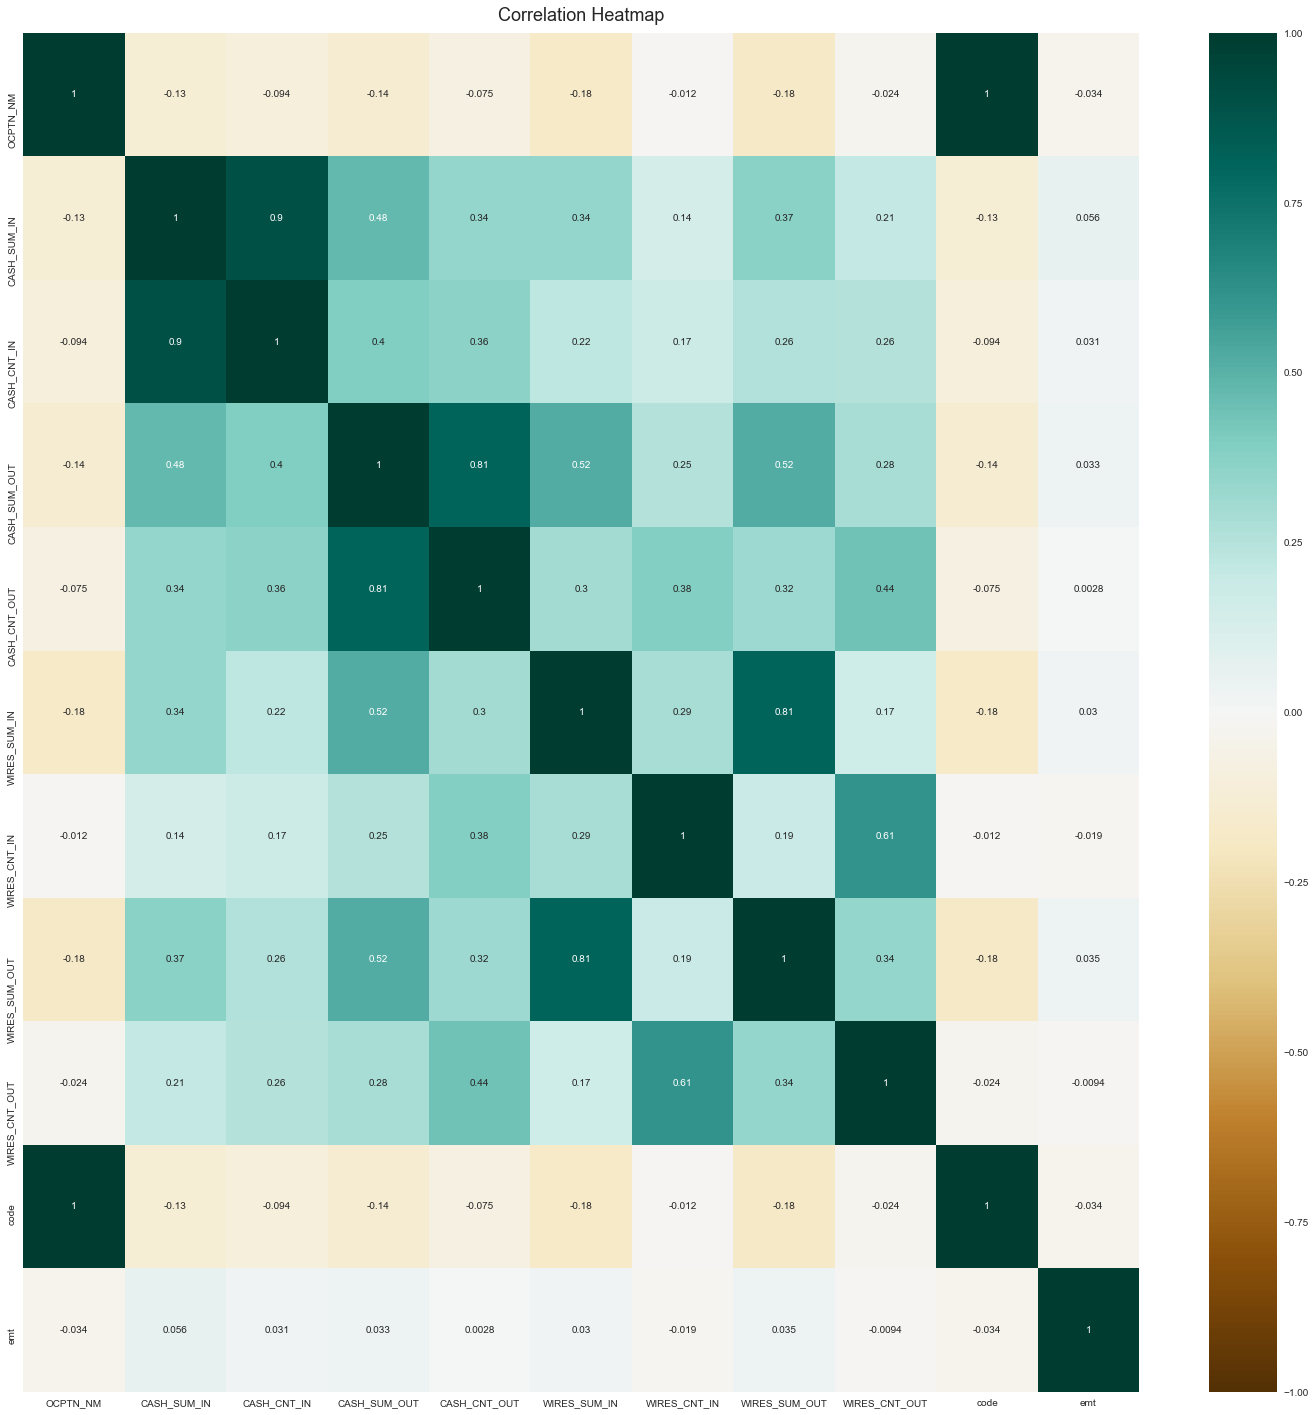

In [171]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

array([[<AxesSubplot: title={'center': 'CASH_CNT_IN'}>,
        <AxesSubplot: title={'center': 'CASH_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_SUM_OUT'}>,
        <AxesSubplot: title={'center': 'code'}>]], dtype=object)

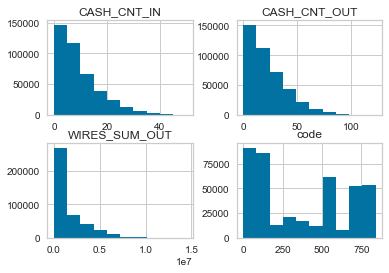

In [172]:
df_train_4_numerical[to_drop].hist()

In [173]:
df_train_4_numerical = df_train_4_numerical.drop(to_drop,axis=1) 
#df_test_4_numerical = df_train_4_numerical.drop(to_drop,axis=1)


In [174]:
corr_matrix=df_train_4_numerical.corr()

upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.70)]

<ipython-input-174-e723ac971bc0>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


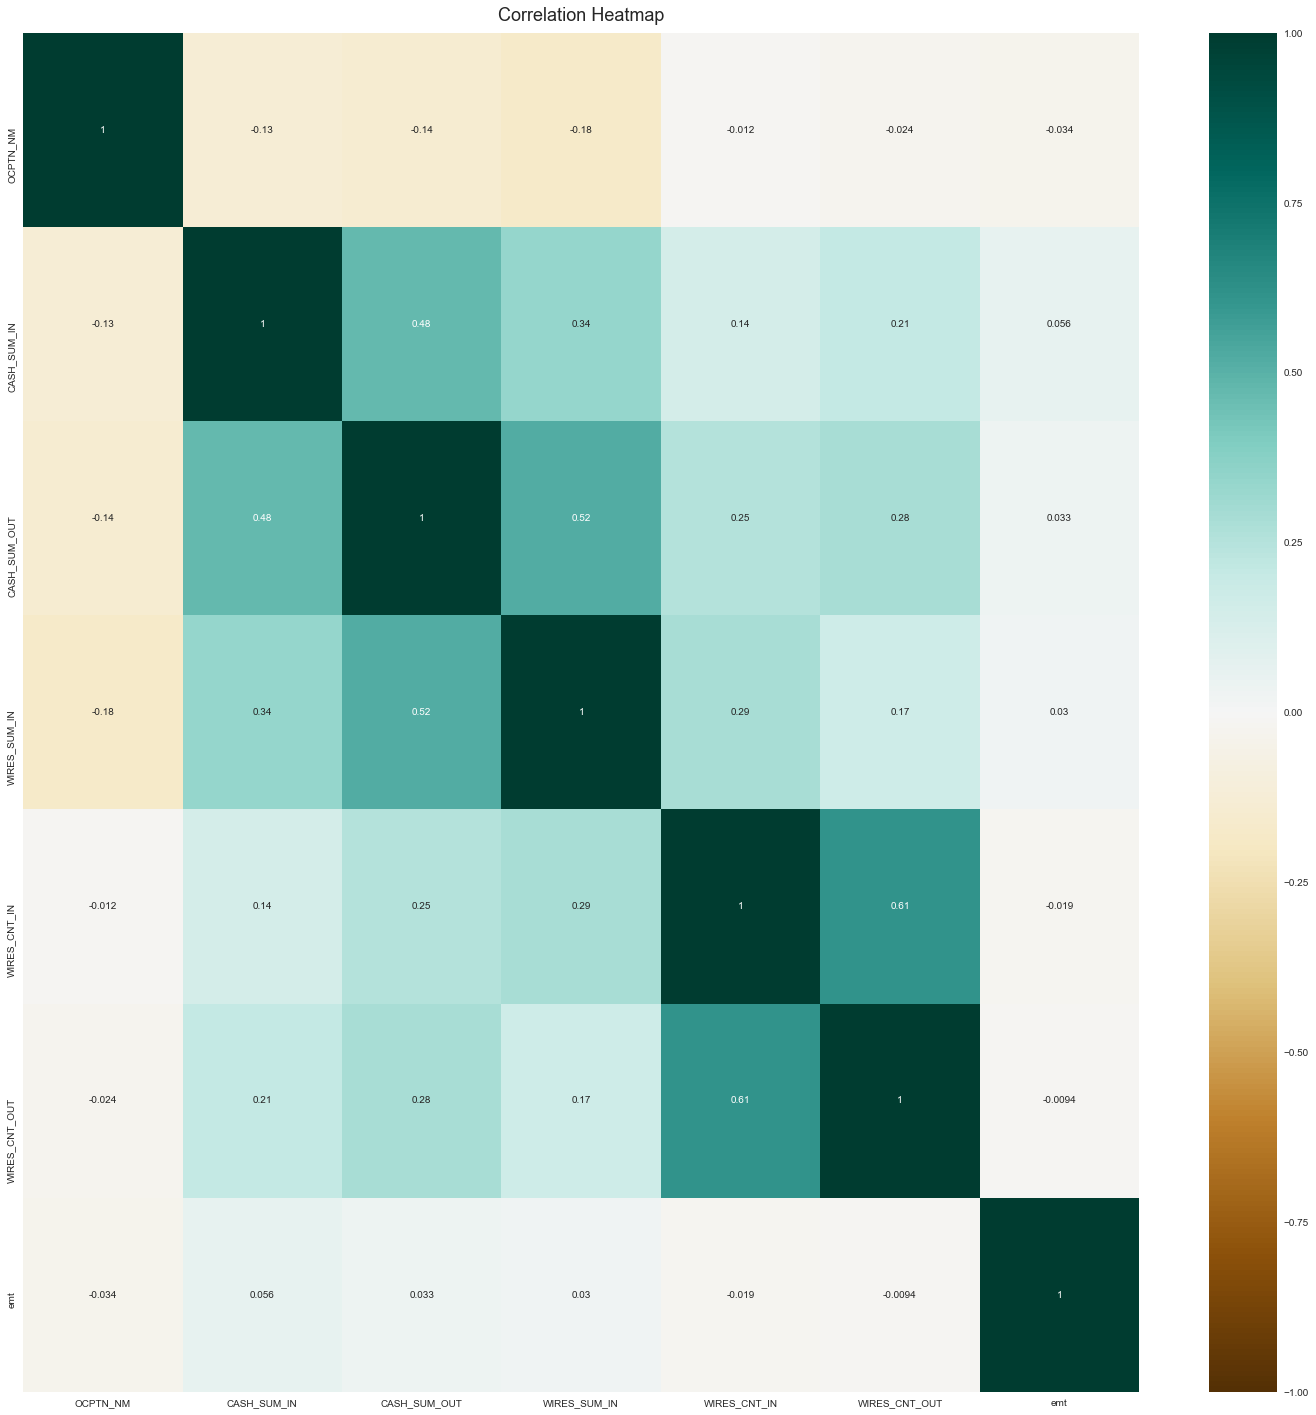

In [175]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap_cor_rem.png', dpi=300, bbox_inches='tight')

In [176]:
#Adding back possible categoricals before scaling
# df_train_4_combined= pd.concat([df_train_4_numerical,df_train_4[categoricals]],axis=1)

**Thus We removed correlated features, we chose all variables which had correlation > 0.80**

### Feature Engineering 4.2 -  Fixing skewness (Using log transformations)

In [177]:
#We have already tried with removal of skewness using box cox transformation but it did'nt work out well, so we removed collinearity and now try log transformation

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_SUM_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'emt'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

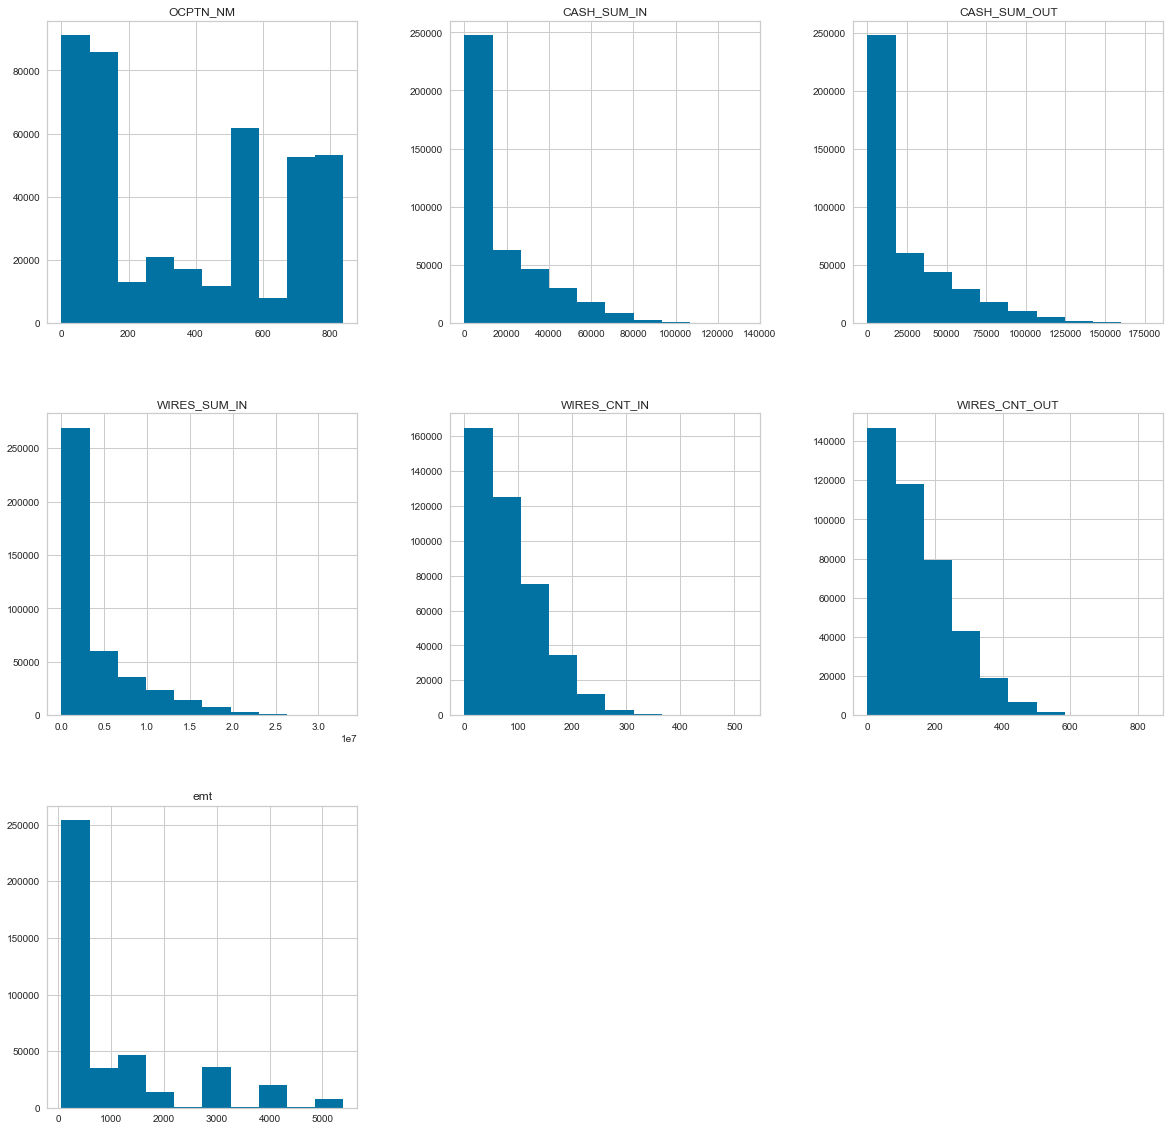

In [178]:
df_train_4_numerical.hist(figsize=(20,20))

In [179]:
# df_train_4_combined = df_train_4_numerical.copy()
# y_4 = y_3.copy()

In [180]:
df_train_4_numerical.isnull().sum().sum()

0

In [181]:
df_train_5_numerical= df_train_4_numerical.copy()

In [182]:
df_train_5_categorical= df_train_4_categorical.copy()

In [183]:
cols_skewed = [col for col in df_train_5_numerical.columns]

In [184]:
def apply_log_trf(np_array_col):
    return np.sign(np_array_col) * np.log(np.abs(np_array_col)+1)

In [185]:
for col in cols_skewed:
    df_train_5_numerical[col]= apply_log_trf(df_train_5_numerical[col])

array([[<AxesSubplot: title={'center': 'OCPTN_NM'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_IN'}>,
        <AxesSubplot: title={'center': 'CASH_SUM_OUT'}>],
       [<AxesSubplot: title={'center': 'WIRES_SUM_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_IN'}>,
        <AxesSubplot: title={'center': 'WIRES_CNT_OUT'}>],
       [<AxesSubplot: title={'center': 'emt'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

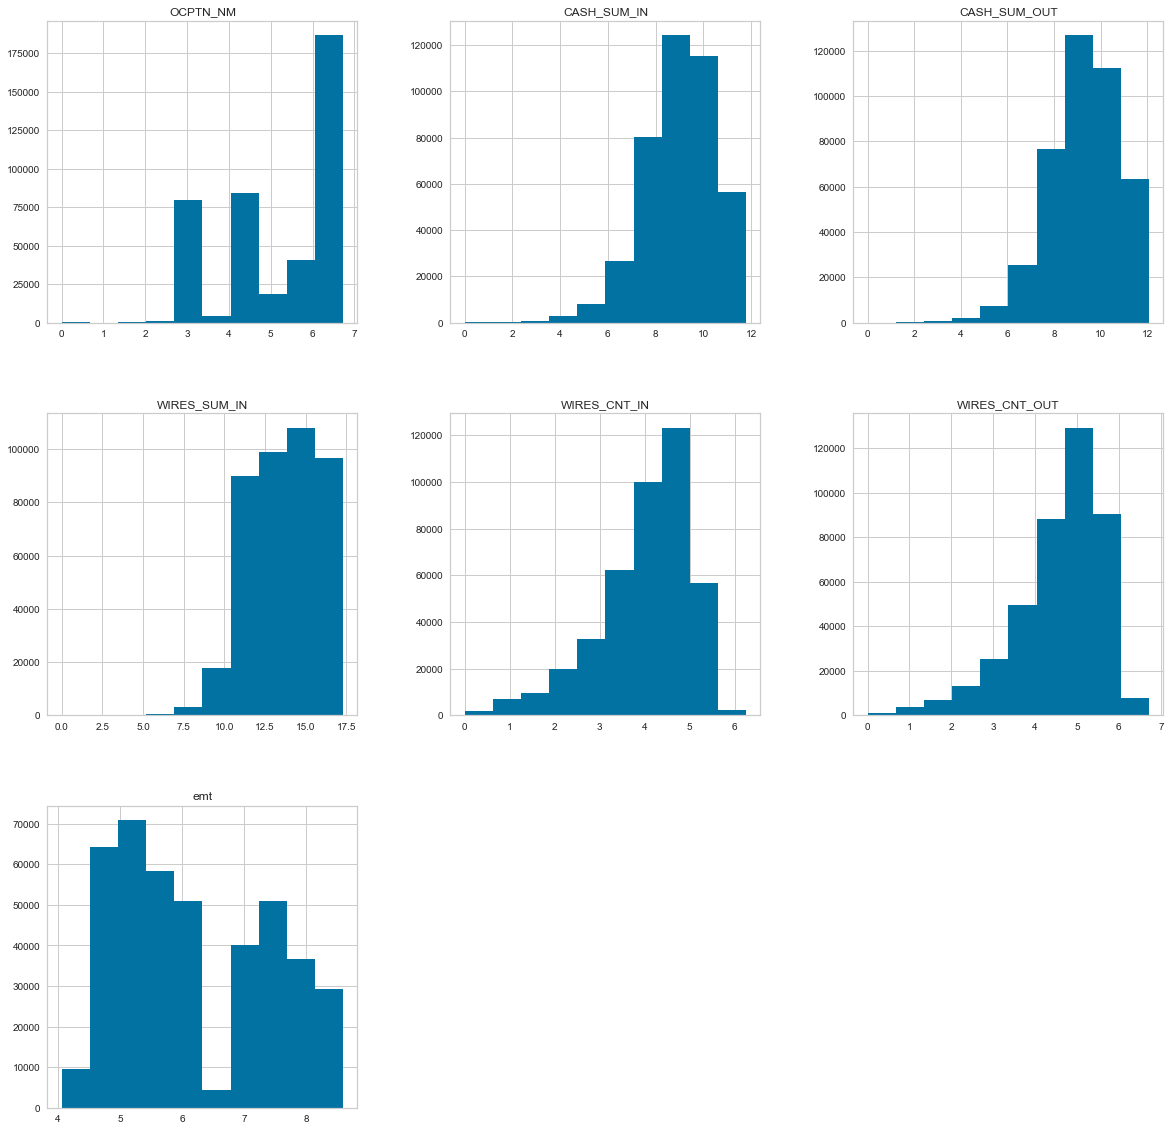

In [186]:
df_train_5_numerical.hist(figsize= (20,20))

In [187]:
df_train_5_numerical

OCPTN_NM  CASH_SUM_IN  CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  \
0       6.586172     7.231019      8.136626     11.930774      1.791759   
1       4.499810     7.479188      8.980936     12.584235      3.526361   
2       6.706862     7.949429     10.300110     13.203626      5.278115   
3       6.242223     8.093703      8.841393     12.022474      3.828641   
4       4.532599     7.400245      8.889368     10.999948      3.135494   
...          ...          ...           ...           ...           ...   
461193  4.836282     8.918228      6.598057     10.364040      4.488636   
461194  4.836282     8.918228      6.598057     10.364040      4.488636   
461195  4.836282     8.918228      6.598057     10.364040      4.488636   
461196  6.148468     8.372580      8.402565     11.061170      4.394449   
461197  4.499810     4.439800      8.423971     10.548284      3.465736   

        WIRES_CNT_OUT       emt  
0            3.828641  7.992133  
1            2.890372  5.732607  
2            5.568345  4.678477  
3            4.844187  6.954949  
4            4.672829  5.039624  
...               ...       ...  
461193       3.496508  4.582567  
461194       3.496508  4.721985  
461195       3.496508  4.650933  
461196       3.806662  7.043612  
461197       3.295837  8.020264  

[415078 rows x 7 columns]

***This transformation seems to be working much better than box cox, so we apply this on test dataset***

In [188]:
#for col in cols_skewed:
#    df_test_5_combined[col]= apply_log_trf(df_test_5_combined[col])

In [189]:
#df_test_5_combined.hist(figsize=(20,20))

# Transformation 

### 1. Transformation - Scaling

In [190]:
# Using min max scaler for scaling we wanted our values to lie between 0-1 because if we use any other scaling it makes tnterpretation difficult if for eg features like 
# total households have values lesss than 0. Then during cluster analysis such negative values cause problem in interpretation. 

In [191]:

scaler = MinMaxScaler()
#df_train_4_numerical
df_train_5_numerical_scaled= pd.DataFrame(scaler.fit_transform(df_train_5_numerical),columns=df_train_5_numerical.columns)
_= scaler.transform(df_train_5_numerical)
# df_test_5_combined_scaled= pd.DataFrame(scaler.transform(df_test_5_combined),columns=df_test_5_combined.columns)

In [192]:
#'BIRTH_DT', 'CUST_ADD_DT' , 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'NAME','GENDER','occupation_risk'

In [193]:
df_train_5_categorical.COUNTRY_RISK_RESIDENCY.value_counts()

Low         408708
High          5956
Moderate       414
Name: COUNTRY_RISK_RESIDENCY, dtype: int64

In [194]:
y_3

0         0
1         0
2         0
3         0
4         0
         ..
461193    0
461194    0
461195    0
461196    0
461197    0
Name: RISK, Length: 415078, dtype: int64

In [195]:
df_train_5_categorical.COUNTRY_RISK_INCOME.replace(['Low','Moderate','High'],[0,1,2],inplace=True)
df_train_5_categorical.COUNTRY_RISK_RESIDENCY.replace(['Low','Moderate','High'],[0,1,2],inplace=True)


In [196]:
df_train_5_categorical.head()


RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  COUNTRY_RISK_INCOME  \
0            1                  1    0.0                    0   
1            1                  1    0.0                    0   
2            1                  1    0.0                    0   
3            1                  1    0.0                    0   
4            1                  1    0.0                    0   

   COUNTRY_RISK_RESIDENCY GENDER occupation_risk  
0                       0      0               0  
1                       0      1               1  
2                       0      0               0  
3                       0      0               0  
4                       0      0               0

In [197]:
df_train_5_categorical.isnull().sum().sum()

0

In [198]:
df_train_5_numerical_scaled.shape

(415078, 7)

In [199]:
df_train_combined= pd.concat([df_train_5_categorical.reset_index(),df_train_5_numerical_scaled.reset_index()],axis=1).drop(['index'],axis=1) #df_train_4_categorical #

In [200]:
df_train_combined

RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  COUNTRY_RISK_INCOME  \
0                 1                  1    0.0                    0   
1                 1                  1    0.0                    0   
2                 1                  1    0.0                    0   
3                 1                  1    0.0                    0   
4                 1                  1    0.0                    0   
...             ...                ...    ...                  ...   
415073            1                  1    0.0                    0   
415074            1                  1    0.0                    0   
415075            1                  1    0.0                    0   
415076            1                  1    0.0                    0   
415077            1                  1    0.0                    0   

        COUNTRY_RISK_RESIDENCY GENDER occupation_risk  OCPTN_NM  CASH_SUM_IN  \
0                            0      0               0  0.977962     0.612705   
1                            0      1               1  0.668164     0.633734   
2                            0      0               0  0.995883     0.673578   
3                            0      0               0  0.926890     0.685803   
4                            0      0               0  0.673033     0.627044   
...                        ...    ...             ...       ...          ...   
415073                       0      1               1  0.718125     0.755668   
415074                       0      1               1  0.718125     0.755668   
415075                       0      1               1  0.718125     0.755668   
415076                       0      1               1  0.912968     0.709433   
415077                       0      1               1  0.668164     0.376197   

        CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT       emt  
0           0.673067      0.689293      0.286243       0.569109  0.867405  
1           0.742908      0.727047      0.563354       0.429640  0.369102  
2           0.852031      0.762832      0.843206       0.827707  0.136630  
3           0.731365      0.694591      0.611645       0.720065  0.638670  
4           0.735334      0.635515      0.500911       0.694593  0.216275  
...              ...           ...           ...            ...       ...  
415073      0.545795      0.598776      0.717083       0.519739  0.115478  
415074      0.545795      0.598776      0.717083       0.519739  0.146225  
415075      0.545795      0.598776      0.717083       0.519739  0.130555  
415076      0.695065      0.639053      0.702036       0.565842  0.658223  
415077      0.696836      0.609421      0.553669       0.489910  0.873609  

[415078 rows x 14 columns]

In [201]:
#df_train_5_combined_scaled = df_train_5_combined_scaled.fillna(method='bfill')
#df_test_5_combined_scaled = df_test_5_combined_scaled.fillna(method='bfill')

In [202]:
df_train_combined_2 = df_train_combined.copy()
y_combined =  y_3.copy()

In [203]:
df_train_combined_2.shape

(415078, 14)

In [204]:
# there seems to be some values nan because of log 0 lets fill with mean
#imputer = KNNImputer(n_neighbors=2)

In [205]:
#df_train_6_combined_scaled= pd.DataFrame(imputer.fit_transform(df_train_6_combined_scaled),columns=df_train_6_combined_scaled.columns)

In [206]:
#df_test_6_combined_scaled= pd.DataFrame(imputer.fit_transform(df_test_6_combined_scaled),columns=df_test_6_combined_scaled.columns)

In [207]:
#df_train_6_combined_scaled

In [208]:
#df_test_6_combined_scaled


In [209]:
df_train_combined_2

RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  COUNTRY_RISK_INCOME  \
0                 1                  1    0.0                    0   
1                 1                  1    0.0                    0   
2                 1                  1    0.0                    0   
3                 1                  1    0.0                    0   
4                 1                  1    0.0                    0   
...             ...                ...    ...                  ...   
415073            1                  1    0.0                    0   
415074            1                  1    0.0                    0   
415075            1                  1    0.0                    0   
415076            1                  1    0.0                    0   
415077            1                  1    0.0                    0   

        COUNTRY_RISK_RESIDENCY GENDER occupation_risk  OCPTN_NM  CASH_SUM_IN  \
0                            0      0               0  0.977962     0.612705   
1                            0      1               1  0.668164     0.633734   
2                            0      0               0  0.995883     0.673578   
3                            0      0               0  0.926890     0.685803   
4                            0      0               0  0.673033     0.627044   
...                        ...    ...             ...       ...          ...   
415073                       0      1               1  0.718125     0.755668   
415074                       0      1               1  0.718125     0.755668   
415075                       0      1               1  0.718125     0.755668   
415076                       0      1               1  0.912968     0.709433   
415077                       0      1               1  0.668164     0.376197   

        CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT       emt  
0           0.673067      0.689293      0.286243       0.569109  0.867405  
1           0.742908      0.727047      0.563354       0.429640  0.369102  
2           0.852031      0.762832      0.843206       0.827707  0.136630  
3           0.731365      0.694591      0.611645       0.720065  0.638670  
4           0.735334      0.635515      0.500911       0.694593  0.216275  
...              ...           ...           ...            ...       ...  
415073      0.545795      0.598776      0.717083       0.519739  0.115478  
415074      0.545795      0.598776      0.717083       0.519739  0.146225  
415075      0.545795      0.598776      0.717083       0.519739  0.130555  
415076      0.695065      0.639053      0.702036       0.565842  0.658223  
415077      0.696836      0.609421      0.553669       0.489910  0.873609  

[415078 rows x 14 columns]

### 2. Transformation - Train Test Split

In [210]:
#Splitting data into train test split
X_train, X_test, y_train, y_test = train_test_split(df_train_combined_2,y_combined, test_size=0.20, random_state=42)

# Unsupervised Phase

### 1. Modelling Process - Segmentation using clustering

In [119]:
# We start with clustering analysis of dtaaste to identify segments.

In [120]:
len(X_train.columns)
y_train

246781    0
60183     1
212999    2
309212    1
23850     1
         ..
289044    1
408065    0
146850    0
163645    1
135583    1
Name: RISK, Length: 332062, dtype: int64

#### Auto encoder to reduce dimensions

In [217]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    '''
    Function takes in a dataframe elbow metric and model to Visualize different
    metrics for clustering.
    
    Args:
    df: Dataframe to remove skewness from.
    elbowmetric: Can be one of "distortion", "silhouette", "calinski_harabasz"
    
    Returns:
    None
    
    '''
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    print(df.shape)
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  
    
    
    
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion



In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


**Implemnted auto encoder to reduce dimension 16 to 2 to ease k means and future scalability purpose**

In [219]:
class CustomDataset(Dataset):
    """Custom Dataset."""

    def __init__(self, X_train):
        self.X_train = X_train
        

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        #if isinstance(idx, torch.Tensor):
        #    idx = idx.tolist()

        #print(type(self.X_train.iloc[idx].values))
        return torch.from_numpy(self.X_train.iloc[idx].values.astype(float)), torch.from_numpy(self.X_train.iloc[idx].values.astype(float)) # make changes to masking here for encoder


In [220]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        print(x.shape)
        ls = self.encoder(x)
        x = self.decoder(ls)
        return x,ls



In [221]:
def train(X_train,y_train,X_test,y_test,latent_dim, n_epochs=100):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_set = CustomDataset(X_train)
    val_set = CustomDataset(X_test)

    # Split into training and test
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #trainset, testset = random_split(dataset, [train_size, test_size])

    # Dataloaders
    trainloader = DataLoader(train_set, batch_size=100000, shuffle=True)
    valloader = DataLoader(val_set, batch_size=100000, shuffle=False)
    

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    net = Autoencoder(input_dim=X_train.shape[1], latent_dim=latent_dim)
    
    net = net.to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), weight_decay=0.0001)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []
    print('Starting Training')
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):
            #if i==3:
            #    break
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(type(labels))

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs,latent_space = net(inputs.float())
            
            #print(outputs.shape,labels.shape)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())
            print(f"Epoch Number {epoch}/{n_epochs} batch {i}/{len(trainloader)} current_loss{running_loss / (i + 1)}")
            

        loss_per_batch.append(running_loss / (i + 1))
        
        running_loss = 0.0

    # Comparing training to test
    dataiter = iter(valloader)
    inputs,labels = next(dataiter)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs,latent_space = net(inputs.float())
    print("Root mean squared error")
    print("Training:", np.sqrt(loss_per_batch[-1]))
    print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

    # Plot training loss curve
    plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
    print((np.arange(len(loss_per_iter), step=4) + 3).shape,loss_per_batch)
    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return net

Starting Training
torch.Size([100000, 14])
Epoch Number 0/100 batch 0/4 current_loss0.45637696981430054
torch.Size([100000, 14])
Epoch Number 0/100 batch 1/4 current_loss0.45056013762950897
torch.Size([100000, 14])
Epoch Number 0/100 batch 2/4 current_loss0.44468480348587036
torch.Size([32062, 14])
Epoch Number 0/100 batch 3/4 current_loss0.4389824867248535
torch.Size([100000, 14])
Epoch Number 1/100 batch 0/4 current_loss0.4102095365524292
torch.Size([100000, 14])
Epoch Number 1/100 batch 1/4 current_loss0.4044369012117386
torch.Size([100000, 14])
Epoch Number 1/100 batch 2/4 current_loss0.3980574905872345
torch.Size([32062, 14])
Epoch Number 1/100 batch 3/4 current_loss0.3914071395993233
torch.Size([100000, 14])
Epoch Number 2/100 batch 0/4 current_loss0.3554753363132477
torch.Size([100000, 14])
Epoch Number 2/100 batch 1/4 current_loss0.34700796008110046
torch.Size([100000, 14])
Epoch Number 2/100 batch 2/4 current_loss0.3382030129432678
torch.Size([32062, 14])
Epoch Number 2/100 ba

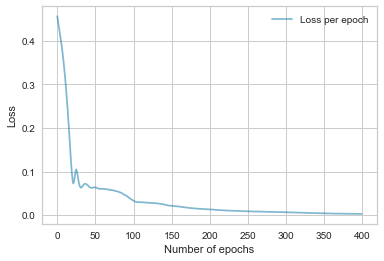

In [128]:
model= train(X_train,y_train,X_test,y_test,latent_dim, n_epochs=100) # 318211

In [148]:
torch.save(model.state_dict(), f'./dnn_ae_v{int(version)}_ls_{latent_dim}.pth')

In [222]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [142]:
X = X_train.reset_index().drop(['index'],axis=1)

In [143]:
'''range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    print(f'Fit started for {n_clusters}')
    clusterer.fit(X)
    print(f'Fit ended for {n_clusters}')
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()'''

'range_n_clusters = [2, 3, 4, 5, 6]\n\nfor n_clusters in range_n_clusters:\n    # Create a subplot with 1 row and 2 columns\n    fig, (ax1, ax2) = plt.subplots(1, 2)\n    fig.set_size_inches(18, 7)\n\n    # The 1st subplot is the silhouette plot\n    # The silhouette coefficient can range from -1, 1 but in this example all\n    # lie within [-0.1, 1]\n    ax1.set_xlim([-0.1, 1])\n    # The (n_clusters+1)*10 is for inserting blank space between silhouette\n    # plots of individual clusters, to demarcate them clearly.\n    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])\n\n    # Initialize the clusterer with n_clusters value and a random generator\n    # seed of 10 for reproducibility.\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)\n    print(f\'Fit started for {n_clusters}\')\n    clusterer.fit(X)\n    print(f\'Fit ended for {n_clusters}\')\n    cluster_labels = clusterer.predict(X)\n\n    # The silhouette_score gives the average value for all the samples.\n    # Th

#### Producing reduced latent space corrosponding to each row in df

In [223]:
#latent_dim= 10 

In [224]:
# Now we do the same for entire dataset
#We use tsne on encoder space
train_set = CustomDataset(df_train_combined_2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainloader = DataLoader(train_set, batch_size=int(df_train_combined_2.shape[0]/2), shuffle=True,drop_last=True) #deliberate different batching to induce batch randomness in clustering
#model = TheModelClass(*args, **kwargs)
model= Autoencoder(input_dim=df_train_combined_2.shape[1], latent_dim=latent_dim)
model.load_state_dict(torch.load(f'./dnn_ae_v{int(version)}_ls_{latent_dim}.pth'))

<All keys matched successfully>

In [225]:
bt = trainloader.sampler

In [226]:
ls= []
model.eval()
for i, (inputs, labels) in tqdm(enumerate(trainloader)):
    #print(i)
    outputs,latent_space = model(inputs.float())
    #print(outputs.unsqueeze(dim = 0).shape)
   # break
    ls.append(latent_space.unsqueeze(dim = 0).cpu().detach().numpy())

1it [00:51, 51.55s/it]

torch.Size([207539, 14])


2it [01:44, 52.32s/it]

torch.Size([207539, 14])


In [227]:
ls_batch_rep = np.stack(ls, axis=1 ).squeeze()


#### Sub sampling data for cliustering

In [229]:
ls_batch_reshaped= ls_batch_rep.reshape(((ls_batch_rep.shape[1]*2,latent_dim))) #change dim as per latent_dim

In [ ]:
#This contains auto encoder latent space rep we apply kmean on this and also separately take models

In [231]:
batch_factor =100

In [156]:
remaining_samples = np.arange(ls_batch_reshaped.shape[0]) 
random_batch = np.random.choice(remaining_samples, int(ls_batch_reshaped.shape[0] / batch_factor), replace = False) 

In [157]:
subsamp = ls_batch_reshaped[random_batch]

#### Choosing the Appropriate Number of Clusters
***We need to cluster and choose appropriate number of clusters, we will employ:***

1. ***The distortion score*** - The distortion is the sum of square errors (SSE) – that's 3 things that need to take place; determine the error, square it, then finally take the sum. The “error” in this case is the difference between each data point coordinates and the centroid coordinates.
2. ***Silhouette Score***- The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters
3. ***Calinski_harabasz Score*** - is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances

***These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:***

Fit started for 2
Fit ended for 2
For n_clusters = 2 The average silhouette_score is : 0.5601361
Fit started for 3
Fit ended for 3
For n_clusters = 3 The average silhouette_score is : 0.61323166
Fit started for 4
Fit ended for 4
For n_clusters = 4 The average silhouette_score is : 0.6561939
Fit started for 5
Fit ended for 5
For n_clusters = 5 The average silhouette_score is : 0.65871894
Fit started for 6
Fit ended for 6
For n_clusters = 6 The average silhouette_score is : 0.5040013


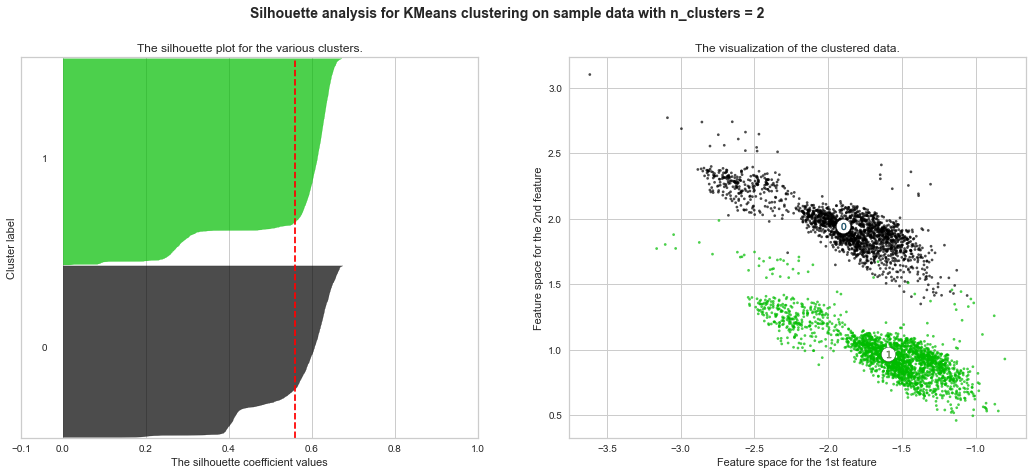

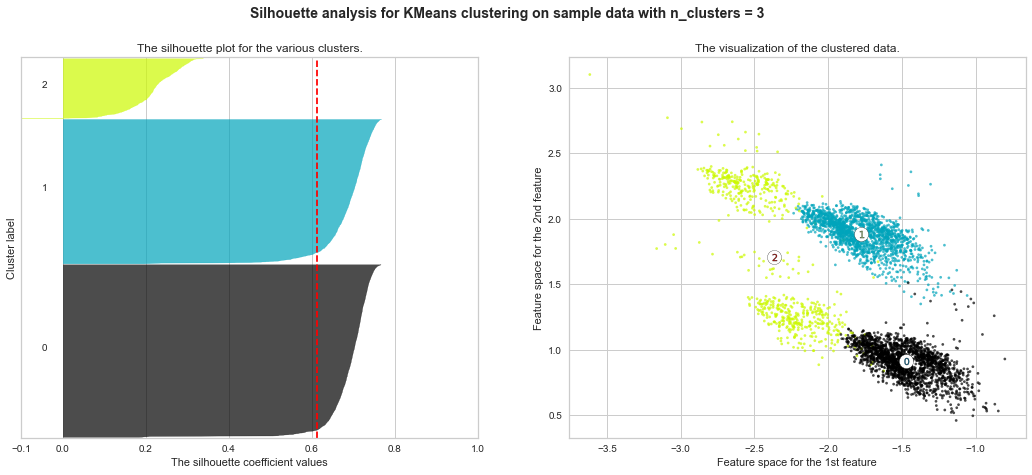

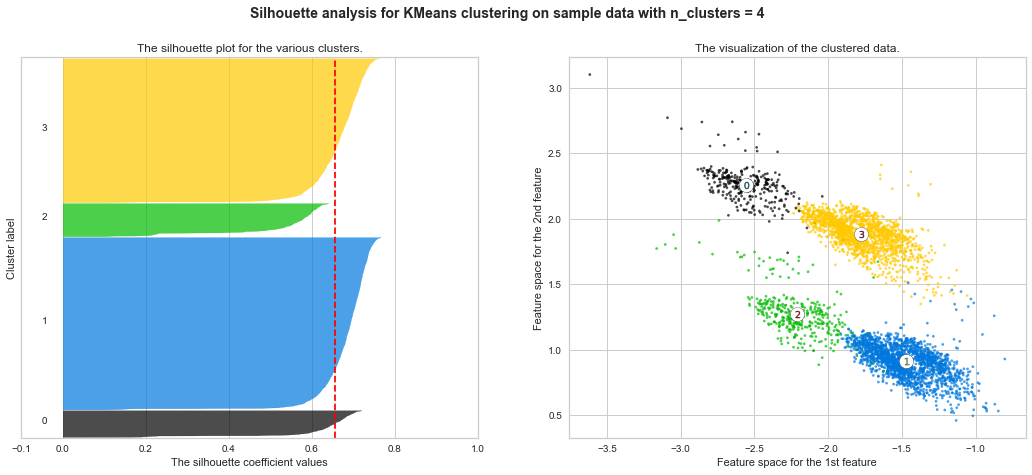

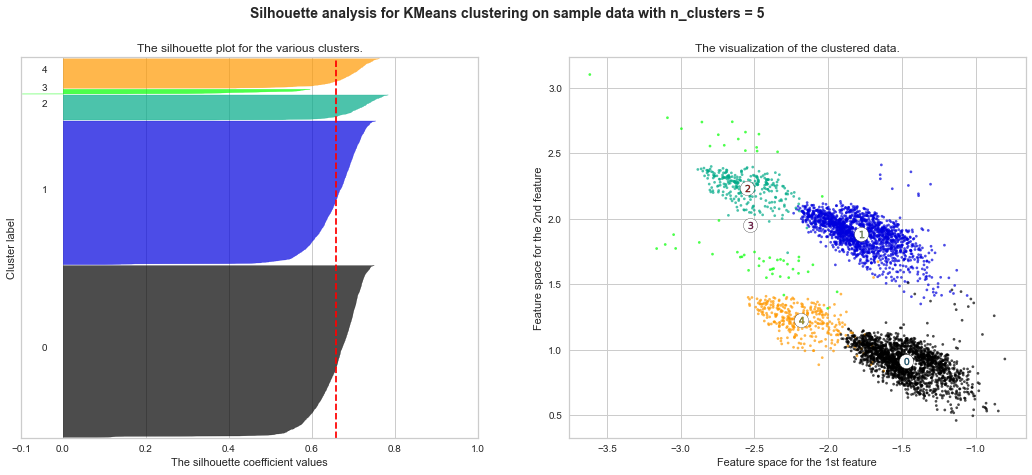

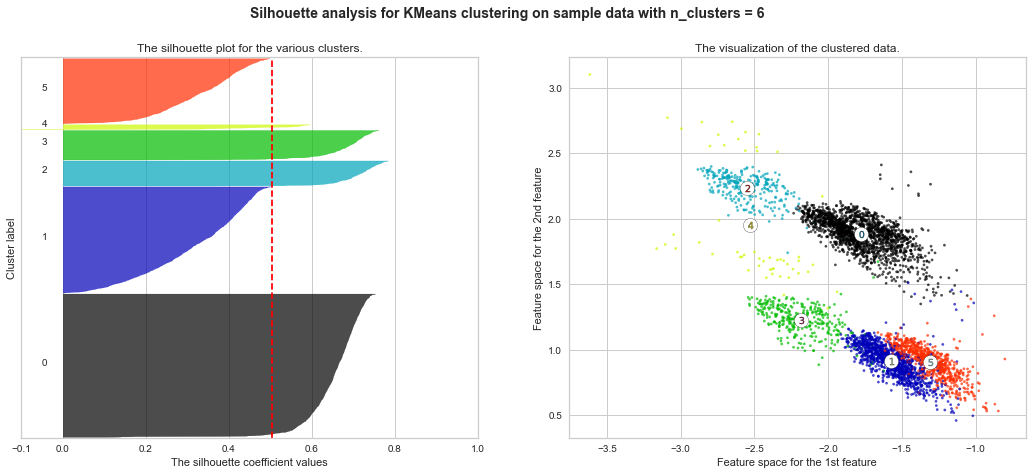

In [158]:
range_n_clusters = [2, 3, 4, 5, 6]
X= subsamp
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,)
    print(f'Fit started for {n_clusters}')
    clusterer.fit(X)
    print(f'Fit ended for {n_clusters}')
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [162]:
from sklearn.cluster import DBSCAN
kmeans_kwargs = {"init": "random","n_init": 20,"max_iter": 1000,"random_state": 1984}
kmeans= KMeans(n_clusters=5, **kmeans_kwargs) # because of high silhouette score

dbscan =  DBSCAN(eps=0.15,min_samples=2)
dbscan.fit(subsamp)

DBSCAN(eps=0.15, min_samples=2)

In [163]:
#clusters = dbscan.fit_predict(subsamp)

In [164]:
kmeans.fit(subsamp)
clusters= kmeans.predict(subsamp)

#### Cluster Visualization using TSNE

In [166]:
from sklearn.manifold import TSNE
Xtsne = TSNE(n_components=2).fit_transform(subsamp)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = clusters
dftsne.columns = ['x1','x2','cluster']

D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Visualized on TSNE 2D')

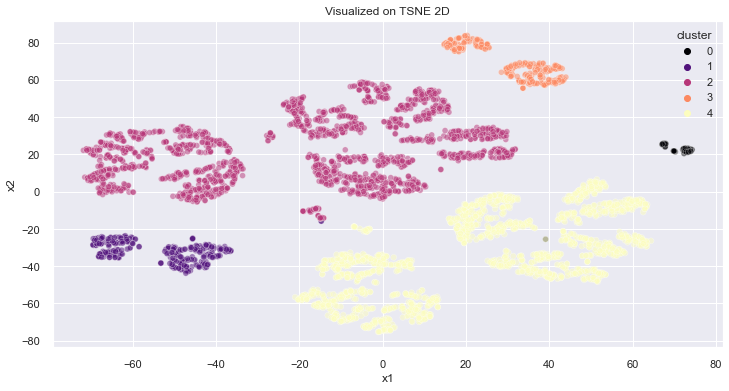

In [168]:

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax,palette="magma")
ax.set_title('Visualized on TSNE 2D')

In [169]:
# So we will make two different clusters features one with dbscan and other with kmeans that was trained on subsample of data

In [170]:
clusters_k2= kmeans.predict(ls_batch_reshaped) 

In [171]:
clusters_k2.shape

(415078,)

#### Creating additional feature of cluster for whole training dataframe

In [196]:
df_train_combined_2['clusters_k5']= None
df_train_combined_2['clusters_k5'] = clusters_k2

In [197]:
df_train_combined_2['customer_add_date']= None
df_train_combined_2['customer_add_date'] = customer_add_date

In [198]:
df_train_combined_2['customer_ids']= None
df_train_combined_2['customer_ids'] = customer_ids

In [199]:
df_train_combined_2['customer_names']= None
df_train_combined_2['customer_names'] = customer_names

In [200]:
df_train_combined_2.head()

RES_CNTRY_CA CNTRY_OF_INCOME_CA PEP_FL  COUNTRY_RISK_INCOME  \
0            1                  1    0.0                    0   
1            1                  1    0.0                    0   
2            1                  1    0.0                    0   
3            1                  1    0.0                    0   
4            1                  1    0.0                    0   

   COUNTRY_RISK_RESIDENCY GENDER occupation_risk  OCPTN_NM  CASH_SUM_IN  \
0                       0      0               0  0.977962     0.616871   
1                       0      1               1  0.668164     0.638042   
2                       0      0               0  0.995883     0.678157   
3                       0      0               0  0.926890     0.690465   
4                       0      0               0  0.673033     0.631307   

   CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT       emt  \
0      0.658327      0.690502      0.290221       0.572647  0.867405   
1      0.726640      0.728322      0.571183       0.432311  0.369102   
2      0.833373      0.764169      0.854923       0.832854  0.136630   
3      0.715349      0.695809      0.620145       0.724542  0.638670   
4      0.719231      0.636630      0.507872       0.698912  0.216275   

   clusters_k5 customer_add_date  customer_ids                  customer_names  
0            3        1966-08-04      362211.0  Kessler, Sherry Dusel Vanmeter  
1            4        1991-09-24      273656.0  Shane Robertson Gauted Denison  
2            2        1968-11-12      956972.0               Mary Miller Neely  
3            1        1976-03-04      878168.0        Elva Woody Hughes Carter  
4            4        1989-09-15      666667.0         J_NES, Susan Norment mt

**Creating a dataframe to ease our future work**

# Supervised Phase

In [283]:
df_train_combined_2['Risk']= None
df_train_combined_2['Risk']= y_combined # but when use ls use y_combined
df_train_combined_2.to_csv('./train_df_cluster_kmeans_5_v5.0.csv')

### 2. Modelling process taking into account this new dataset (dataframe) .
We will conduct following experiments:
1. Training various supervised models on this dataset (dataset incl of cluster)
2. Training various supervised moodels on dataset (not including cluster)
3. Pass the dataset through AE and do supervised learning on Latent space obtained.

In [ ]:
# we divide data into train test split

In [25]:
df= pd.read_csv('./train_df_cluster_kmeans_5_v5.0.csv')


In [27]:
y= df.Risk
df= df.drop(['Risk'],axis= 1)

In [28]:
#df.to_csv('./train_df_cluster_kmeans_5_v5.0.csv')

In [29]:
df= df.drop(['customer_add_date','customer_ids','customer_names'],axis=1)

In [31]:
df= df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [32]:
df.head()

RES_CNTRY_CA  CNTRY_OF_INCOME_CA  PEP_FL  COUNTRY_RISK_INCOME  \
0             1                   1     0.0                    0   
1             1                   1     0.0                    0   
2             1                   1     0.0                    0   
3             1                   1     0.0                    0   
4             1                   1     0.0                    0   

   COUNTRY_RISK_RESIDENCY  GENDER  occupation_risk  OCPTN_NM  CASH_SUM_IN  \
0                       0       0                0  0.977962     0.616871   
1                       0       1                1  0.668164     0.638042   
2                       0       0                0  0.995883     0.678157   
3                       0       0                0  0.926890     0.690465   
4                       0       0                0  0.673033     0.631307   

   CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT       emt  \
0      0.658327      0.690502      0.290221       0.572647  0.867405   
1      0.726640      0.728322      0.571183       0.432311  0.369102   
2      0.833373      0.764169      0.854923       0.832854  0.136630   
3      0.715349      0.695809      0.620145       0.724542  0.638670   
4      0.719231      0.636630      0.507872       0.698912  0.216275   

   clusters_k5  
0            3  
1            4  
2            2  
3            1  
4            4

In [33]:
df= df.drop(['clusters_k5'],axis=1)

In [34]:
df

RES_CNTRY_CA  CNTRY_OF_INCOME_CA  PEP_FL  COUNTRY_RISK_INCOME  \
0                  1                   1     0.0                    0   
1                  1                   1     0.0                    0   
2                  1                   1     0.0                    0   
3                  1                   1     0.0                    0   
4                  1                   1     0.0                    0   
...              ...                 ...     ...                  ...   
415073             1                   1     0.0                    0   
415074             1                   1     0.0                    0   
415075             1                   1     0.0                    0   
415076             1                   1     0.0                    0   
415077             1                   1     0.0                    0   

        COUNTRY_RISK_RESIDENCY  GENDER  occupation_risk  OCPTN_NM  \
0                            0       0                0  0.977962   
1                            0       1                1  0.668164   
2                            0       0                0  0.995883   
3                            0       0                0  0.926890   
4                            0       0                0  0.673033   
...                        ...     ...              ...       ...   
415073                       0       1                1  0.718125   
415074                       0       1                1  0.718125   
415075                       0       1                1  0.718125   
415076                       0       1                1  0.912968   
415077                       0       1                1  0.668164   

        CASH_SUM_IN  CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT  \
0          0.616871      0.658327      0.690502      0.290221       0.572647   
1          0.638042      0.726640      0.728322      0.571183       0.432311   
2          0.678157      0.833373      0.764169      0.854923       0.832854   
3          0.690465      0.715349      0.695809      0.620145       0.724542   
4          0.631307      0.719231      0.636630      0.507872       0.698912   
...             ...           ...           ...           ...            ...   
415073     0.760805      0.533843      0.599826      0.727048       0.522970   
415074     0.760805      0.533843      0.599826      0.727048       0.522970   
415075     0.760805      0.533843      0.599826      0.727048       0.522970   
415076     0.714256      0.679844      0.640173      0.711792       0.569360   
415077     0.378755      0.681576      0.610490      0.561363       0.492956   

             emt  
0       0.867405  
1       0.369102  
2       0.136630  
3       0.638670  
4       0.216275  
...          ...  
415073  0.115478  
415074  0.146225  
415075  0.130555  
415076  0.658223  
415077  0.873609  

[415078 rows x 14 columns]

#### Training various supervised moodels on dataset (not including cluster)

In [36]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut,train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier,LogisticRegression
#from sklearn.naive_bayes import 
from sklearn.neural_network import MLPClassifier
# check xgboost version
import xgboost
from sklearn import svm
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error,explained_variance_score,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.20, random_state=42)

In [39]:
from sklearn.metrics import classification_report

classification_reports= []
from sklearn.metrics import accuracy_score, recall_score,precision_score,confusion_matrix,f1_score


In [40]:
model_names = []
cv_10_accs= []
classification_reports= []
accs =[]
f1_score_macros=[] 
p_scores =[]
r_scores = []

In [41]:
def test_maes(model,X_train,y_train,X_test,y_test,model_name):
    '''
    
    Function takes in a model, train and test dataset and model name to return
    various metrics.
    
    Args:
    model: ML trained model to test on.
    X_train: Train dataset
    y_train: Train y dataset
    X_test: Test dataset.
    y_test: Test y dataset
    model_name: Name of the model.
    
    Returns:
    model,model_name,explained_variance,r2_scor,mape,mae,cv10_mae,predictions: model,model's name, <All metrics>.
    
    '''
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    #explained_variance= explained_variance_score(y_test, predictions)
    #r2_scor= r2_score(y_test, predictions)
    #mape = mean_absolute_percentage_error(y_test, predictions)
    #mae= mean_absolute_error(y_test, predictions)

    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy',
                             cv=cv, n_jobs=-1)
    cv10_mae = scores.mean()*-1
    cr = classification_report(y_test, predictions)
    acc =  accuracy_score(y_test, predictions)
    f1_score_macro = f1_score(y_test, predictions, average='macro')
    p_score= precision_score(y_test, predictions ,average='macro')
    r_score= recall_score(y_test, predictions ,average='macro')
    return model,model_name,cr, cv10_mae,acc,f1_score_macro,p_score,r_score,predictions

In [42]:
lm = LogisticRegression()
lm,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(lm,X_train,y_train,X_test,y_test,model_name= 'LogisticRegression')

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

In [43]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [44]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[   29 30426     0]
 [   23 38460     0]
 [   12 14066     0]]


<AxesSubplot: >

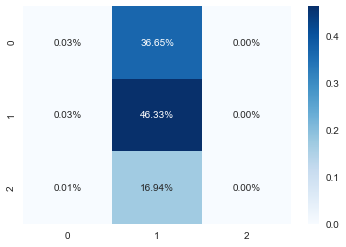

In [45]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot: >

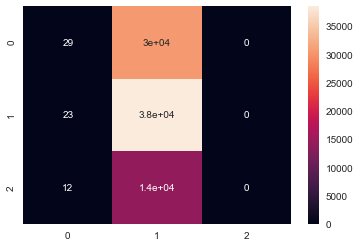

In [46]:
sns.heatmap(cf_matrix, annot=True)

In [50]:
dt = DecisionTreeClassifier(random_state=0)
dt,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(dt,X_train,y_train,X_test,y_test,model_name= 'DecisionTree')

In [51]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [52]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[14220 11823  4412]
 [11937 21293  5253]
 [ 4214  4760  5104]]


<AxesSubplot: >

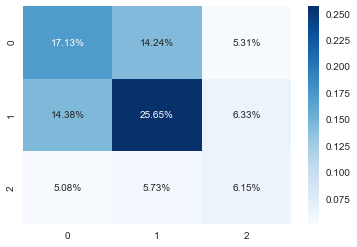

In [53]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [54]:
f1_score_macros

[0.21177524823445737, 0.4597126122274506]

In [55]:
rfc= RandomForestClassifier(n_estimators=40)
rfc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(rfc,X_train,y_train,X_test,y_test,model_name= 'RandomForestClassifier')

In [56]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [57]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[14859 14009  1587]
 [10444 26375  1664]
 [ 3937  6130  4011]]


<AxesSubplot: >

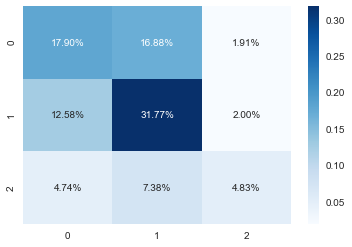

In [58]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [59]:
f1_score_macros

[0.21177524823445737, 0.4597126122274506, 0.4981181850693626]

In [60]:
knn_2= KNeighborsClassifier(n_neighbors=5)
knn_2,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(knn_2,X_train,y_train,X_test,y_test,model_name= 'knn_2')

In [61]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [65]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[14693 14419  1343]
 [16553 20215  1715]
 [ 6381  6688  1009]]


<AxesSubplot: >

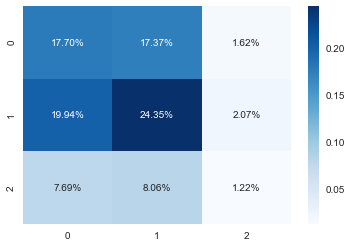

In [66]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [67]:
f1_score_macros

[0.21177524823445737,
 0.4597126122274506,
 0.4981181850693626,
 0.34981721343384486]

In [69]:
etc= ExtraTreesClassifier()
etc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc,X_train,y_train,X_test,y_test,model_name= 'ETC')

In [70]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [71]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[14267 14591  1597]
 [ 9730 27044  1709]
 [ 3529  6432  4117]]


<AxesSubplot: >

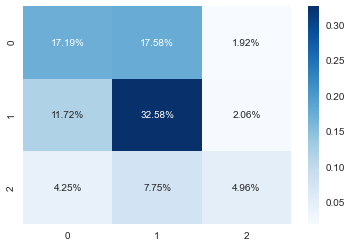

In [72]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [279]:
svm_c= svm.SVC()
svm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(svm_c,X_train,y_train,X_test,y_test,model_name= 'SVM-classifier')

In [280]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [281]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[36274     5    40]
 [  230 29683  2868]
 [  320  7340  6256]]


<AxesSubplot: >

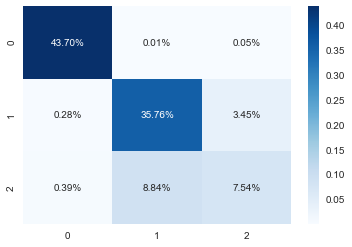

In [282]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [240]:
from xgboost import XGBClassifier


In [241]:
xgbc= XGBClassifier()
xgbc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(xgbc,X_train,y_train,X_test,y_test,model_name= 'XGB-classifier')

In [242]:
model_names.append(model_name)
cv_10_accs.append(cv10_acc)
classification_reports.append(cr)
accs.append(acc)
f1_score_macros.append(f1_score_macro)
p_scores.append(p_score)
r_scores.append(r_score)


In [243]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[36414    10    14]
 [   51 29344  3228]
 [   88  4256  9611]]


<AxesSubplot: >

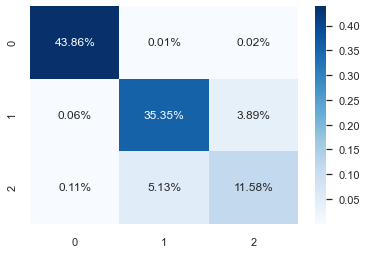

In [249]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [245]:
# Now we include clusters in the dataset


#### Training various supervised moodels on dataset (including cluster)

In [75]:
df_c= pd.read_csv('./train_df_cluster_kmeans_5_v5.0.csv')
df_c= df_c.drop(['customer_add_date','customer_ids','customer_names','Unnamed: 0','Unnamed: 0.1'],axis=1)
#df= df.drop([],axis=1)

In [77]:
y= df_c.Risk
df_c = df_c.drop(['Risk'],axis=1)

In [81]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_c,y, test_size=0.20, random_state=42)

In [84]:
X_train_c

RES_CNTRY_CA  CNTRY_OF_INCOME_CA  PEP_FL  COUNTRY_RISK_INCOME  \
221405             1                   1     0.0                    0   
54498              1                   1     0.0                    0   
190955             1                   1     1.0                    0   
277072             1                   1     0.0                    0   
21787              1                   1     0.0                    0   
...              ...                 ...     ...                  ...   
259178             1                   1     0.0                    0   
365838             1                   1     0.0                    0   
131932             1                   1     0.0                    0   
146867             1                   1     0.0                    0   
121958             1                   1     0.0                    0   

        COUNTRY_RISK_RESIDENCY  GENDER  occupation_risk  OCPTN_NM  \
221405                       0       1                1  0.977962   
54498                        0       0                0  0.668164   
190955                       0       1                1  0.995883   
277072                       0       1                1  0.668164   
21787                        0       0                0  0.483785   
...                        ...     ...              ...       ...   
259178                       0       1                1  0.668164   
365838                       0       0                0  0.995883   
131932                       0       0                0  0.995883   
146867                       0       1                1  0.668164   
121958                       0       1                1  0.668164   

        CASH_SUM_IN  CASH_SUM_OUT  WIRES_SUM_IN  WIRES_CNT_IN  WIRES_CNT_OUT  \
221405     0.504672      0.638947      0.607339      0.372962       0.651630   
54498      0.917082      0.859772      0.965124      0.725217       0.843856   
190955     0.857794      0.832786      0.789077      0.778132       0.828216   
277072     0.914963      0.942314      0.931197      0.844690       0.866001   
21787      0.530672      0.000000      0.883739      0.507872       0.508715   
...             ...           ...           ...           ...            ...   
259178     0.962794      0.834468      0.900177      0.759882       0.759091   
365838     0.755294      0.668748      0.712948      0.707742       0.844914   
131932     0.615902      0.686964      0.504267      0.616585       0.607318   
146867     0.623769      0.805276      0.723900      0.112273       0.291049   
121958     0.492885      0.688076      0.791992      0.336818       0.462325   

             emt  clusters_k5  
221405  0.365954            2  
54498   0.367475            2  
190955  0.478180            2  
277072  0.718752            4  
21787   0.196791            4  
...          ...          ...  
259178  0.372919            2  
365838  0.876803            4  
131932  0.354573            2  
146867  0.371918            2  
121958  0.375976            2  

[332062 rows x 15 columns]

In [105]:
c_model_names = []
c_cv_10_accs= []
c_classification_reports= []
c_accs =[]
c_f1_score_macros=[] 
c_p_scores =[]
c_r_scores = []

In [107]:
lm_c = LogisticRegression()
lm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(lm_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'LogisticRegression')

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

In [108]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [109]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[   38 30417     0]
 [   29 38454     0]
 [   17 14061     0]]


<AxesSubplot: >

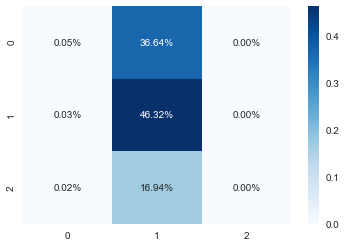

In [110]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot: >

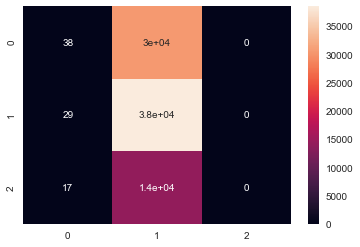

In [111]:
sns.heatmap(cf_matrix, annot=True)

In [112]:
c_f1_score_macros

[0.21197313877131985]

In [113]:
dt_c = DecisionTreeClassifier(random_state=0)
dt_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(dt_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'DecisionTree')

In [114]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [115]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[13966 12037  4452]
 [12060 21077  5346]
 [ 4306  4867  4905]]


<AxesSubplot: >

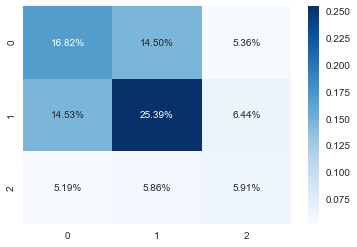

In [116]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [124]:
c_f1_score_macros

[0.21197313877131985, 0.45054937398581013, 0.4578409118783127]

In [118]:
f1_score_macros

[0.21177524823445737,
 0.4597126122274506,
 0.4981181850693626,
 0.34981721343384486,
 0.5000064092422937]

In [119]:
rf_c= RandomForestClassifier(n_estimators=40)
rf_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(rfc,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'RandomForestClassifier')

In [120]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [121]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[13953 15356  1146]
 [10686 26644  1153]
 [ 4119  7136  2823]]


<AxesSubplot: >

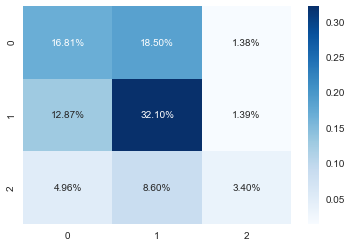

In [122]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [269]:
c_model_names

['LogisticRegression', 'DecisionTree', 'RandomForestClassifier']

In [270]:
knn_2_c= KNeighborsClassifier(n_neighbors=2)
knn_2_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(knn_2_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'knn_2')

D:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [271]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [272]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[36402    23    13]
 [  379 30166  2078]
 [  559  8234  5162]]


<AxesSubplot: >

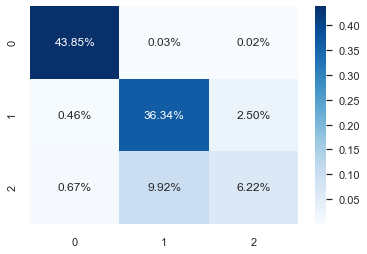

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
etc_c= ExtraTreeClassifier(n_neighbors=2)
etc_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'ExtraTreeClassifier')

NameError: name 'ExtraTreeClassifier' is not defined

In [ ]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
svm_c= svm.SVC()
svm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(svm_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'SVM-classifier')

In [ ]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from xgboost import XGBClassifier


In [ ]:
xgbc_c= XGBClassifier()
xgbc_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(xgbc_c,X_train_c,y_train_c,X_test_c,y_test_c,model_name= 'XGB-classifier')

In [ ]:
c_model_names.append(model_name)
c_cv_10_accs.append(cv10_acc)
c_classification_reports.append(cr)
c_accs.append(acc)
c_f1_score_macros.append(f1_score_macro)
c_p_scores.append(p_score)
c_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [237]:
y_combined.shape

(415078,)

**We test for auto encoder ls and model on this**

#### Training various supervised moodels on Latent space derived features from train dataset (not including cluster)

In [ ]:
#check y saved above

In [240]:
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(ls_batch_reshaped,y_combined, test_size=0.20, random_state=42)

In [241]:
X_train_ls

array([[-1.4460883 ,  1.9023435 ,  0.6958548 , ...,  0.34883615,
         0.86490965, -1.2251477 ],
       [-2.5226338 ,  2.192207  ,  1.1942327 , ...,  1.1133909 ,
         0.32036218, -1.5856209 ],
       [-2.0561242 ,  1.9060507 ,  1.069679  , ...,  0.26675242,
         0.49221212, -0.9666953 ],
       ...,
       [-3.1301343 ,  2.4762402 ,  1.1807967 , ...,  1.696664  ,
        -0.7540758 , -1.3256445 ],
       [-1.6402584 ,  0.96637225, -0.07894577, ...,  0.18453316,
         0.4771854 , -1.0233489 ],
       [-1.9951756 ,  1.9945163 ,  0.96528184, ...,  0.24775288,
         0.59306765, -0.8397825 ]], dtype=float32)

In [242]:
ls_model_names = []
ls_cv_10_accs= []
ls_classification_reports= []
ls_accs =[]
ls_f1_score_macros=[] 
ls_p_scores =[]
ls_r_scores = []

In [244]:
lm_ls = LogisticRegression()
lm_ls,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(lm_ls,X_train_ls,y_train_ls,X_test_ls,y_test_ls,model_name= 'LogisticRegression')

D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

In [245]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [246]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[36319     0     0]
 [32781     0     0]
 [13916     0     0]]


<AxesSubplot: >

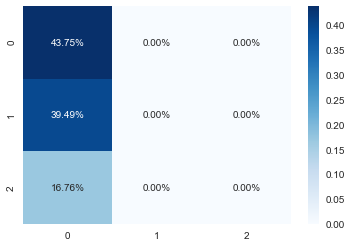

In [247]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot: >

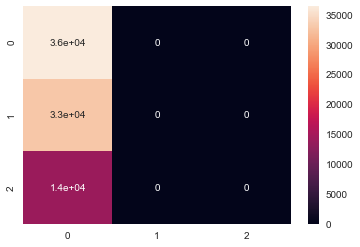

In [248]:
sns.heatmap(cf_matrix, annot=True)

In [249]:
c_f1_score_macros

[0.21197313877131985, 0.45054937398581013, 0.4578409118783127]

In [250]:
ls_f1_score_macros

[0.2028966075892795]

In [252]:
dt_ls = DecisionTreeClassifier(random_state=0)
dt_ls,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(dt_ls,X_train_ls,y_train_ls,X_test_ls,y_test_ls,model_name= 'DecisionTree')

In [253]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [254]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[15728 14072  6519]
 [14282 12655  5844]
 [ 6102  5344  2470]]


<AxesSubplot: >

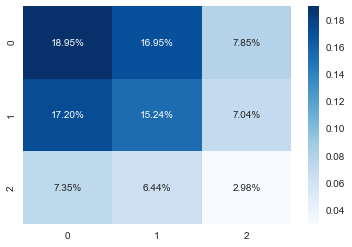

In [255]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [256]:
c_f1_score_macros

[0.21197313877131985, 0.45054937398581013, 0.4578409118783127]

In [257]:
f1_score_macros

[0.21177524823445737,
 0.4597126122274506,
 0.4981181850693626,
 0.34981721343384486,
 0.5000064092422937]

In [263]:
ls_f1_score_macros

[0.2028966075892795, 0.33213149560637095]

In [259]:
rf_ls= RandomForestClassifier(n_estimators=40)
rf_ls,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(rf_ls,X_train_ls,y_train_ls,X_test_ls,y_test_ls,model_name= 'RandomForestClassifier')

In [269]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [270]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[20203 14341  1775]
 [18340 12867  1574]
 [ 7717  5494   705]]


<AxesSubplot: >

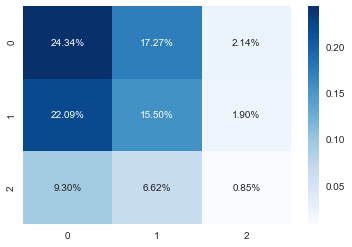

In [271]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [272]:
ls_cv_10_accs

[-0.4374460214715244, -0.3735906930550377, -0.4081381411526929]

In [273]:
cv_10_accs

[-0.4637057192651888,
 -0.4080659811429464,
 -0.4618026011268216,
 -0.4178110838784912,
 -0.4689337264094201]

In [274]:
ls_accs

[0.43749397706466225, 0.371651247952202, 0.40684928206610776]

In [268]:
ls_model_names

['LogisticRegression', 'DecisionTree']

In [270]:
knn_2_ls= KNeighborsClassifier(n_neighbors=2)
knn_2_ls,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(knn_2_ls,X_train_ls,y_train_ls,X_test_ls,y_test_ls,model_name= 'knn_2')

D:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [271]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [272]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[36402    23    13]
 [  379 30166  2078]
 [  559  8234  5162]]


<AxesSubplot: >

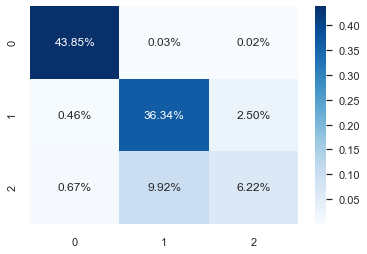

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
etc_ls= ExtraTreeClassifier(n_neighbors=2)
etc_ls,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc_ls,X_train,y_train,X_test,y_test,model_name= 'ExtraTreeClassifier')

In [ ]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
etc= ExtraTreesClassifier()
etc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(etc,X_train,y_train,X_test,y_test,model_name= 'ETC')

In [ ]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
svm_c= svm.SVC()
svm_c,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(svm_c,X_train,y_train,X_test,y_test,model_name= 'SVM-classifier')

In [ ]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from xgboost import XGBClassifier


In [ ]:
xgbc= XGBClassifier()
xgbc,model_name,cr, cv10_acc,acc,f1_score_macro,p_score,r_score,predictions = test_maes(xgbc,X_train,y_train,X_test,y_test,model_name= 'XGB-classifier')

In [ ]:
ls_model_names.append(model_name)
ls_cv_10_accs.append(cv10_acc)
ls_classification_reports.append(cr)
ls_accs.append(acc)
ls_f1_score_macros.append(f1_score_macro)
ls_p_scores.append(p_score)
ls_r_scores.append(r_score)


In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')